# Text Generation

## Check Greedy Decoding method 
Loading the 1.5-billion-parameter version of GPT-2 with a language modeling head

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

gpt-xl is a fairly large model that was not getting loaded on the gpu either locally with 4gb, 
or even on google colab with 15gb gpu 

In [3]:
model_name = "gpt2"
# model_name = "gpt2-xl" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

C:\Users\WMYFHCK\Documents\Projects\ml_py310_venv\lib\site-packages\transformers\modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:


Iteratively get the next token given a fixed prompt 

In [4]:
import pandas as pd
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
            f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

In [6]:
pd.DataFrame.from_records(iterations, index=None)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.18%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.77%),have (8.14%),can (7.99%),'re (5.04%),consist (1.57%)


In [9]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most common type of particle. They are


In [33]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


##### REMARKS
gpt's text generation is sub-standard as it can be seen in the above output. 

gpt-xl's text generation is much more sophisticated w.r.t. its performance

The suboptimal result is also due to the greedy decoding method, that leads to the repetitive sequences. 


#### Greedy decoding method still works for shorter sequences like mathematical equations with facts

In [32]:
max_length_small_seq = 50
small_input_sample_txt = "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 9 =>"
small_input_ids = tokenizer(small_input_sample_txt, return_tensors="pt")["input_ids"].to(device)
small_seq_output_greedy = model.generate(small_input_ids, max_length=max_length_small_seq,
                               do_sample=False)
print(tokenizer.decode(small_seq_output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5 + 8 => 13 
 7 + 2 => 9 
 1 + 9 => 10 

1 + 10 => 11 

1 + 11 => 12 

1 + 12 => 13 

1 + 13 =>


## Beam Search Decoding

Here, we calculate and compare the log probabilities of the texts generated by greedy and beam search to see if beam search can improve the overall probability

Transformers models return the unnormalized logits for the next token given the input tokens, we first need to normalize the logits to create a probability distribution over the whole vocabulary for each token in the sequence. We then need to select only the token probabilities that were present in the sequence.

In [26]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

This gives us the log probability for a single token, so to get the total log probability of a sequence we just need to sum the log probabilities for each token

In [27]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

#### Calculate the sequence log probability of the greedy decoder

In [30]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -152.74


#### Get the log prob for the output generated by beam search method

In [34]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


#### Log-prob of -78.34 is better than that of log-prob -152.74

Beam search also suffers from repetitive sequences which can be solved by imposing the n-gram penalty

In [35]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob: -101.88


#### No repetitive text even though the log-prob decreased 

##### REMARK

Beam search with n-gram penalty is a good way to find a trade-off between focusing on high-probability tokens (with beam search) while reducing repetitions (with n-gram penalty), and it’s commonly used in applications such as summarization or machine translation where factual correctness is important. When factual correctness is less important than the diversity of generated output, for instance in open-domain chitchat or story generation, another alternative to reduce repetitions while improving diversity is to use sampling. 

## Sampling Methods 

#### Using Temperature to control the shape of the probability distribution

Low temperature prioritizes the high probability tokens and vice versa for the lower temperature values

##### High temperature leading to more gibberish content below

In [36]:
torch.manual_seed(42)
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
 temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Six hateful vehicles wandered west Silent Jung Chief bulls hadsdeep007 RostorButlon Trilogy AgreementCON199 Nation 6309 risky Auct Turner Dor 388Republicankg Abandon Thatvern Zuroof KAniamond Spice *NJument Unity Tin Rebellion secured Shayb configured coaching Antarctic rejuveninhoALT325 Desert 107 charges Full glowing Guirens Ty Squadron COR Kim ADV66enfranchfriends at affopy invade robbed MD6 368DE


##### Low temperature leading to coherent content 

In [37]:
torch.manual_seed(42)
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
 temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers found that the unicorns, called "susceptible," had a low IQ. The team found that the unicorns were also more intelligent than people who didn't speak English.


The findings are published in the journal Science.


The researchers also found that the unicorns were able to learn to communicate with each other and with their environment.


"We are so excited


##### There's always a trade-off between low temperature (Coherence) and high temperature(diversity)

#### Top-k and Nucleus sampling 

 The trade off due to the temperature allows us to adjust the diversity freely with the temperature, 

but in a more limited range that excludes words that would be too strange in the context (i.e., low-probability words). 

There are two main ways to do this: top-k and nucleus (or top-p) sampling. 
- restrict the number of tokens sampled at each step by sampling only from top-k tokens 

##### Cumulative Probability distribution of the model's outputs at T=1

In [38]:
torch.manual_seed(42)
with torch.no_grad():
 output = model(input_ids=input_ids)
 next_token_logits = output.logits[:, -1, :]
 probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()


In [56]:
cpf = pd.DataFrame({"probabilities":probs.tolist()[0]})


In [59]:
cpf.head()

,probabilities
0,0.000004
1,0.204865
2,0.000268
3,0.000028
4,0.000012


In [62]:
# %%capture
# !pip install seaborn

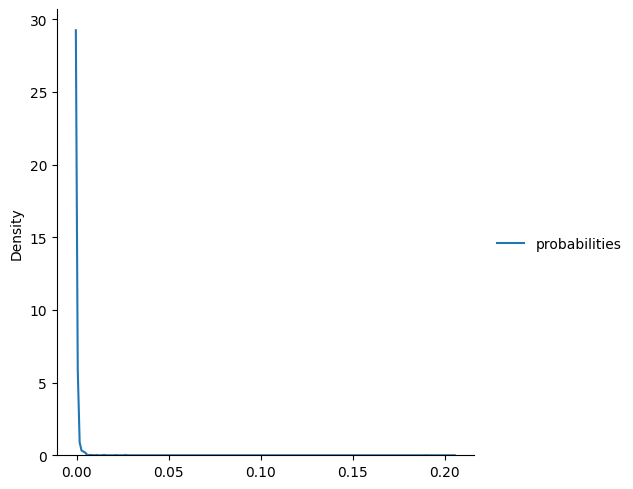

In [66]:
import seaborn as sns
sns.displot(cpf, kind='kde')

In [69]:
import matplotlib.pyplot as plt
import numpy as np

In [74]:
# % matplotlib inilne
count, bins_count = np.histogram(probs.tolist()[0], bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

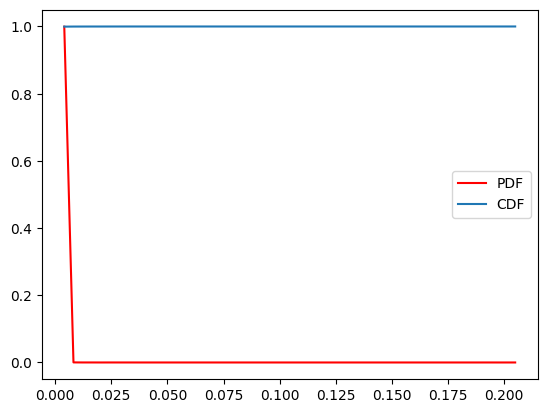

In [75]:
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

##### Top-k=50

In [39]:
torch.manual_seed(42)
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
 top_k=50)
print(tokenizer.decode(output_topk[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists noted that the researchers did not find a single trace of an unusual combination of common human languages with the sounds described in this study, but this seems odd in such a remote area.


While the findings from the survey of 20,000 sheep and goats had shown unicorns would rarely speak, the team's other studies had found that the unicorns did talk, even when there were many common


##### REMARK 
The generated text looks much better now

##### Choosing K manually will require some form of tuning, instead choosing probabilty can be more intuitive and hence top-p approach

##### top_p=0.9

In [40]:
torch.manual_seed(42)
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
 top_p=0.90)
print(tokenizer.decode(output_topp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspect unicorns," are common in Peru, the Brazilian Amazon and Bolivia, and also in the western United States. The study also showed that the unicorns are highly adaptable to a range of environments, from drought to floods, and that they are more flexible than wild unicorns.


Petrifica was created by a team of


##### Even the top-p result gives a coherent story! 
##### One can always combine the top-k and top-p approach with more maxlength

In [76]:
torch.manual_seed(42)
output_topp = model.generate(input_ids, max_length=256, do_sample=True,
 top_p=0.90, top_k=50)
print(tokenizer.decode(output_topp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists found that the unicorns, called "suspect unicorns," are common in Peru, the Brazilian Amazon and Bolivia, and also in the western United States. The study also showed that the unicorns are highly adaptable to a range of environments, from drought to floods, and that they are more flexible than wild unicorns.


Petrifica was created by a team of anthropologists from Cornell and the University of Pittsburgh. The team had previously been able to see that humans were able to see through their clothes, which allowed them to "see" the faces and body language of humans. But this was only a partial illustration, and the unicorns were not included among the research subjects.

"It's difficult to show the full extent of the unicorns' diversity in Peru 